# What's in the Wind?: Evaluating Air Quality Trends in the United States Since 1990

Contributors: Alexander Heger, Yu Ting Hung, Ishan Nagrani, Lingxuan Wang, Fanfei Zhao

----

### Table of Contents

> 1. [Introduction](#part1)
> 2. [Challenges](#part2)
> 3. [Data Cleaning](#part3)
> 4. [Data Analysis](#part4)
> 5. [Conclusions and Future Scope](#part5)
> 6. [References](#part6)

> [Appendix A](#appa)

----


<a id="part1"></a>
## Part 1: Introduction 

### 1.1. Problem Statement

Our goal is to illustrate trends in air quality in the United States, identifying which pollutants have contributed most to air quality changes over the years. Our analysis will include how weather, natural disasters, and select world events affect air quality as measured by the U.S. Environmental Protection Agency (EPA). We will use Google Cloud Platform's (GCP) Dataproc service to distribute and interact with daily air quality information from the EPA's Historical Air Quality data set (hosted on BigQuery) which includes data from collection points across the U.S. dating back to 1990.

### 1.2. Motivation

Air pollution is a significant problem with adverse health outcomes, so understanding air quality trends is crucial for effective management strategies. In this study, we explore six pollutants that were key drivers of the 1990 Clean Air Act whose standards brought about the generation of our data set. We chose this problem based on our knowledge that historical air quality data can identify sources of pollution, inform targeted interventions, and aid in the development of evidence-based approaches that promote environmental sustainability and protect public health.

### 1.3. Data Source

The EPA Historical Air Quality data set is hosted here on __[Google Cloud Platform](https://console.cloud.google.com/marketplace/product/epa/historical-air-quality)__.

The EPA's documentation for the data set can be found __[here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html)__. 

The data set takes on the following schema:

|        | Field Name          | Type    | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   |   |   |   |   |
|--------|---------------------|---------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|---|---|
| **1**  | state_code          | STRING  | The FIPS code of the state in which the monitor resides.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   |   |   |   |   |
| **2**  | county_code         | STRING  | The FIPS code of the county in which the monitor resides.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |   |   |   |   |   |
| **3**  | site_num            | STRING  | A unique number within the county identifying the site.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |   |   |   |   |   |
| **4**  | parameter_code      | INTEGER | The AQS code corresponding to the parameter measured by the monitor.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |   |   |   |   |   |
| **5**  | poc                 | INTEGER | This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |   |   |   |   |   |
| **6**  | latitude            | FLOAT   | The monitoring site’s angular distance north of the equator measured in decimal degrees.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   |   |   |   |   |
| **7**  | longitude           | FLOAT   | The monitoring site’s angular distance east of the prime meridian measured in decimal degrees.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   |   |   |   |   |
| **8**  | datum               | STRING  | The Datum associated with the Latitude and Longitude measures.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   |   |   |   |   |
| **9**  | parameter_name      | STRING  | The name or description assigned in AQS to the parameter measured by the monitor. Parameters may be pollutants or non-pollutants.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   |   |   |   |   |
| **10** | sample_duration     | STRING  | The length of time that air passes through the monitoring device before it is analyzed (measured). So, it represents an averaging period in the atmosphere (for example, a 24-hour sample duration draws ambient air over a collection filter for 24 straight hours). For continuous monitors, it can represent an averaging time of many samples (for example, a 1-hour value may be the average of four one-minute samples collected during each quarter of the hour).                                                                                                                                                                                                             |   |   |   |   |   |
| **11** | pollutant_standard  | STRING  | A description of the ambient air quality standard rules used to aggregate statistics. (See description at beginning of document.)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   |   |   |   |   |
| **12** | date_local          | DATE    | The calendar date for the summary. All daily summaries are for the local standard day (midnight to midnight) at the monitor.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |   |   |   |   |   |
| **13** | units_of_measure    | STRING  | The unit of measure for the parameter. QAD always returns data in the standard units for the parameter. Submitters are allowed to report data in any unit and EPA converts to a standard unit so that we may use the data in calculations.                                                                                                                                                                                                                                                                                                                                                                                                                                           |   |   |   |   |   |
| **14** | event_type          | STRING  | Indicates whether data measured during exceptional events are included in the summary. A wildfire is an example of an exceptional event; it is something that affects air quality, but the local agency has no control over. No Events means no events occurred. Events Included means events occurred and the data from them is included in the summary. Events Excluded means that events occurred but data from them is excluded from the summary. Concurred Events Excluded means that events occurred but only EPA concurred exclusions are removed from the summary. If an event occurred for the parameter in question, the data will have multiple records for each monitor. |   |   |   |   |   |
| **15** | observation_count   | INTEGER | The number of observations (samples) taken during the day.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |   |   |   |   |   |
| **16** | observation_percent | FLOAT   | The percent representing the number of observations taken with respect to the number scheduled to be taken during the day. This is only calculated for monitors where measurements are required (e.g., only certain parameters).                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   |   |   |   |   |
| **17** | arithmetic_mean     | FLOAT   | The average (arithmetic mean) value for the day.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   |   |   |   |   |
| **18** | first_max_value     | FLOAT   | The highest value for the day.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   |   |   |   |   |
| **19** | first_max_hour      | INTEGER | The hour (on a 24-hour clock) when the highest value for the day (the previous field) was taken.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   |   |   |   |   |
| **20** | aqi                 | INTEGER | The Air Quality Index for the day for the pollutant, if applicable.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |   |   |   |   |   |
| **21** | method_code         | INTEGER | An internal system code indicating the method (processes, equipment, and protocols) used in gathering and measuring the sample. The method name is in the next column.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |   |   |   |   |   |
| **22** | method_name         | STRING  | A short description of the processes, equipment, and protocols used in gathering and measuring the sample.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |   |   |   |   |   |
| **23** | local_site_name     | STRING  | The name of the site (if any) given by the State, local, or tribal air pollution control agency that operates it.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   |   |   |   |   |
| **24** | address             | STRING  | The approximate street address of the monitoring site.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |   |   |   |   |   |
| **25** | state_name          | STRING  | The name of the state where the monitoring site is located.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   |   |   |   |   |
| **26** | county_name         | STRING  | The name of the county where the monitoring site is located.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |   |   |   |   |   |
| **27** | city_name           | STRING  | The name of the city where the monitoring site is located. This represents the legal incorporated boundaries of cities and not urban areas.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   |   |   |   |   |
| **28** | cbsa_name           | STRING  | The name of the core bases statistical area (metropolitan area) where the monitoring site is located.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |   |   |   |   |   |
| **29** | date_of_last_change | DATE    | The date the last time any numeric values in this record were updated in the AQS data system.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |   |   |   |   |   |


----


<a id="part2"></a>
## Part 2: Challenges

### 2.1. Computing

The first challenge we encountered was related to computing. Given that we needed to deal with six tables, it became necessary for our cluster to scale up in order to run multiple notebooks which can be computationally expensive. To address this challenge, we decided to append the six tables together. This approach simplified the data processing pipeline and reduced the computational load, thereby enabling more efficient analysis.

### 2.2. Data Wrangling

The second challenge was related to data wrangling. We first chose six pollutants based on the information provided by [AirNow](https://www.airnow.gov/aqi/aqi-basics/). They are Ground-level Ozone, Particle Pollution (including PM2.5 and PM10), Carbon Monoxide, Sulfur Dioxide, and Nitrogen Dioxide. Each pollutant has distinct measurements that need to be analyzed separately, which made data wrangling a complex task. Our approach was to develop a standardized data cleaning and preprocessing pipeline that could be applied uniformly across all pollutants. In this way, we can ensure that our analysis is accurate and reliable.

----


<a id="part3"></a>
## Part 3 : Data Cleaning

### 3.1. Append Tables

We elected to append six data tables, containing information on our pollutants of interest, into one large table in order to limit the need for many smaller tables relevant to distinct calculations.  The following code blocks detail how we merged all our information into one place.  

We begin by reading each table name and loading it in a sequence, before using the `unionByName` method to merge each table into `merged_df`.

In [2]:
table_names = [
    "bigquery-public-data.epa_historical_air_quality.no2_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.pm10_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.o3_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.co_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.so2_daily_summary",
]

# Read all tables
dataframes = {}
for table_name in table_names:
    dataframes[table_name] = spark.read \
        .format("bigquery") \
        .option("table", table_name) \
        .load()

# Create merged_df
merged_df = dataframes[table_names[0]]

# Append all tables to merged_df
for table_name in table_names[1:]:
    merged_df = merged_df.unionByName(dataframes[table_name])
    
# Validate schema of merged_df
merged_df.printSchema()

root
 |-- state_code: string (nullable = true)
 |-- county_code: string (nullable = true)
 |-- site_num: string (nullable = true)
 |-- parameter_code: long (nullable = true)
 |-- poc: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter_name: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: date (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: long (nullable = true)
 |-- observation_percent: double (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: long (nullable = true)
 |-- aqi: long (nullable = true)
 |-- method_code: long (nullable = true)
 |-- method_name: string (nullable = true)
 |-- local_site_name: string (nullable = true)
 |

### 3.2. Remove Redundant Columns

Through early exploration we identified 8 columns that were not relevant to our analysis.  We drop those columns from `merged_df` and rename the new table `all_pollutants_merged`. 

In [3]:
columns_to_drop = [
    "observation_percent",
    "first_max_value",
    "first_max_hour",
    "method_code",
    "method_name",
    "address",
    "cbsa_name",
    "date_of_last_change",
]

# Drop columns_to_drop
all_pollutants_merged = merged_df.drop(*columns_to_drop)

Next, we show how many rows our combined table contains, compared to the count of rows in each of the six individual pollutant tables.

In [4]:
# Count the number of rows in all_pollutants_merged
print("There are {} rows in the data table.".format(all_pollutants_merged.count()))

# Count the number of rows in each distinct table
table_counts = {}
for table_name, df in dataframes.items():
    count = df.count()
    table_counts[table_name] = count
    print(f"Total count of {table_name}: {count}")

There are 48629007 rows in the data table.


Total count of bigquery-public-data.epa_historical_air_quality.no2_daily_summary: 4523485
Total count of bigquery-public-data.epa_historical_air_quality.pm10_daily_summary: 4860727
Total count of bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary: 6589958
Total count of bigquery-public-data.epa_historical_air_quality.o3_daily_summary: 11141508
Total count of bigquery-public-data.epa_historical_air_quality.co_daily_summary: 8990270
Total count of bigquery-public-data.epa_historical_air_quality.so2_daily_summary: 12523059


In [5]:
# Prevent Pandas from delimiting columns
import pandas as pd
pd.set_option('display.max_columns', None)

# Show head of all_pollutants_merged
all_pollutants_merged.limit(3).toPandas()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,arithmetic_mean,aqi,local_site_name,state_name,county_name,city_name
0,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-09-18,Parts per billion,None,20,3.900000,15,None,North Dakota,Mercer,Beulah
1,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-03-01,Parts per billion,None,21,3.619048,18,None,North Dakota,Mercer,Beulah
2,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-06-11,Parts per billion,None,21,0.000000,0,None,North Dakota,Mercer,Beulah


### 3.3. Null & Negative Values Analysis

Finally, we want to know how many missing or negative values exist in our dataset.  Since all of our measurements indicate a quantity of an observed pollutant, none should be negative.

In [6]:
from pyspark.sql.functions import col, when, isnull, count

# Show count of all null values by column
all_pollutants_merged.select([count(when(isnull(col(each_col)), 1)).alias(f"{each_col}")\
                              for each_col in all_pollutants_merged.columns]).toPandas()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,arithmetic_mean,aqi,local_site_name,state_name,county_name,city_name
0,0,0,0,0,0,0,0,0,0,0,1911323,0,0,0,0,0,12664142,7858526,0,0,0


It appears there are 1,911,323 null values for `pollutant_standard`, 12,664,142 null values for `aqi`, and 7,858,526 null values for `local_site_name`.  Since neither of these variables is critical to our analyses, we will not impute any missing values for now.

In [7]:
# Count all negative arithmetic_mean values in the data set
all_pollutants_merged.select("parameter_name", "arithmetic_mean")\
.where(all_pollutants_merged["arithmetic_mean"] < 0).count()

212017

In [8]:
# Show count of all negative arithmetic_mean values by pollutant
neg_count = all_pollutants_merged.groupBy("parameter_name")\
.agg(count(when(col("arithmetic_mean") < 0, 1)).alias("count"))
neg_count.toPandas()

,parameter_name,count
0,Nitrogen dioxide (NO2),8772
1,PM2.5 - Local Conditions,29369
2,Ozone,33
3,Carbon monoxide,13535
4,Sulfur dioxide,159838
5,PM10 Total 0-10um STP,470


There are 212,017 negative measurements for `arithmetic_mean`, which is impractical for this dataset.  Since `arithmetic_mean` is a key variable in our later analyses, we will impute these values to 0 and then cache the data set.

In [9]:
# Impute negative values
imputed_mean = when(all_pollutants_merged['arithmetic_mean'] < 0, 0)\
.otherwise(all_pollutants_merged['arithmetic_mean'])

#Replace original values with imputed values
all_pollutants_merged = all_pollutants_merged.withColumn('arithmetic_mean', imputed_mean)

# Show head of all_pollutants_merged
all_pollutants_merged.limit(3).toPandas()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,arithmetic_mean,aqi,local_site_name,state_name,county_name,city_name
0,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-09-18,Parts per billion,None,20,3.900000,15,None,North Dakota,Mercer,Beulah
1,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-03-01,Parts per billion,None,21,3.619048,18,None,North Dakota,Mercer,Beulah
2,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-06-11,Parts per billion,None,21,0.000000,0,None,North Dakota,Mercer,Beulah


In [10]:
# Check to ensure there are no negative values remaining
all_pollutants_merged.cache()
all_pollutants_merged.select("parameter_name", "arithmetic_mean")\
.where(all_pollutants_merged["arithmetic_mean"] < 0).count()

0

Our cleaned table is now ready to be used for data analysis.

-----

<a id="part4"></a>
## Part 4: Data Analysis

### 4.1. Range of Dates Measured

In order to better understand the timeframe that this dataset measures, we examine the earliest and latest measurement dates. This table contains measurements from January 1, 1990 to June 1, 2022.

In [31]:
from pyspark.sql.functions import min, max

# Show min and max dates
all_pollutants_merged.select(min("date_local"), max("date_local")).toPandas()

,min(date_local),max(date_local)
0,1990-01-01,2022-06-01


### 4.2. Number of Sites

We then asked, how many sites does the EPA leverage to measure air pollutants in accordance with the Clean Air Act of 1990?  In fact, there are 3,327 distinctly numbered sites in our table.

In [11]:
# Print count of distinct sites by site_num
sites = all_pollutants_merged.select('site_num', 'state_code').distinct()
print("There are ", sites.count(), " sites.")

There are  3327  sites.


### 4.3. Map of Measurement Sites

The following is an interactive map of the 813 distinct measurement sites located throughout the United States. Sites appear to be the most dense in California, Texas and Oklahoma, and New England with noticeable concentrations along the North-South Interstate corridors, I-5, I-35, and I-95. We assess that this is due to population density in addition to the occurrence of key weather events in these same regions.  An embedded image of this map is included as Appendix A.

In [22]:
import folium

site_locations = all_pollutants_merged.dropDuplicates(['site_num', 'state_code'])\
.select('latitude', 'longitude').where((all_pollutants_merged['latitude'] > 0) &
                                       (all_pollutants_merged['longitude'] < 0)).toPandas()

# Define the center of the US
center = [39.828, -98.58]
# Create the map
m = folium.Map(location=center, zoom_start=2.75, tiles="Stamen Terrain")

# Add a marker at the location
for i, j in site_locations.iterrows():
    lat = j['latitude']
    # print(lat)
    long = j['longitude']
    # print(long)
    marker = folium.Marker([lat, long]).add_to(m)
    
# Show the map
m

### 4.4. Summary Statistics

#### 4.4.1. The Highest Recorded Values for Each Pollutant
To gain an overview of the six pollutants, we ran the following codes to identify the highest recorded values of each pollutant in this dataset, along with their corresponding dates.

In [14]:
from pyspark.sql.functions import desc, asc, struct, max

# Identify key stats for each pollutant
stats = all_pollutants_merged.groupBy("parameter_name").agg(
    max(struct("arithmetic_mean", "date_local")).alias("max_value"))

# Generate stats table
stats = stats.withColumn("max_arithmetic_mean", stats["max_value"]["arithmetic_mean"]) \
                                 .withColumn("max_date_local", stats["max_value"]["date_local"]) \
                                 .select("parameter_name", "max_arithmetic_mean", "max_date_local")

stats.toPandas()

,parameter_name,max_arithmetic_mean,max_date_local
0,Carbon monoxide,48.100000,2008-06-04
1,Nitrogen dioxide (NO2),231.166667,2000-01-19
2,Ozone,0.258118,1996-08-20
3,PM10 Total 0-10um STP,20750.000000,2001-05-02
4,PM2.5 - Local Conditions,824.104167,2020-09-17
5,Sulfur dioxide,1170.485714,2010-01-17


#### 4.4.2. The Greatest Change in One Day for Each Pollutant

To discover if natural events caused significant fluctuations in the six pollutants, we used a window function to create a 1 day lag in `arithmetic_mean` for each pollutant. Our analysis revealed high magnitude fluctuations in PM10 and Sulfur Dioxide, but significantly smaller magnitude changes in Ozone. This coincides with higher standadrd deviations for PM10 and SO2 (see 4.4.3.), but it is also important to note that the highest reported flucuations here may indicate new measurement sites coming online.

In [18]:
from pyspark.sql.functions import lag, abs, col, lead
from pyspark.sql.window import Window

# Create window
w = Window.partitionBy('parameter_name').orderBy('date_local')

# Lag by arithmetic_mean
lagged = all_pollutants_merged.withColumn('lagged_mean', lag('arithmetic_mean', 1).over(w)) \
                           .withColumn('lagged_date', lead('date_local', 1).over(w))

# Take difference of two means
diff = lagged.withColumn('diff', abs(col('arithmetic_mean') - col('lagged_mean')))

# Find and show the highest difference
max_diff = diff.groupBy('parameter_name').agg({'diff': 'max', 'lagged_date': 'first'}) \
               .withColumnRenamed('max(diff)', 'max_diff') \
               .withColumnRenamed('first(lagged_date)', 'date_of_max_diff') \
               .select('parameter_name', 'max_diff', 'date_of_max_diff')

max_diff.toPandas()

,parameter_name,max_diff,date_of_max_diff
0,Carbon monoxide,48.100000,1990-01-01
1,PM10 Total 0-10um STP,20731.000000,1990-01-01
2,PM2.5 - Local Conditions,814.400000,1997-04-04
3,Sulfur dioxide,1057.800000,1990-01-01
4,Ozone,0.230118,1990-01-01
5,Nitrogen dioxide (NO2),216.155797,1990-01-01


#### 4.4.3. Standard Deviation of Each Pollutant

A high standard deviation indicates that the values are widely spread out from the mean, while a low standard deviation indicates that the values are clustered closer to the mean. In this case, PM10 has the highest standard deviation which may suggest that there is a large variation in the pollutant levels over time or across different locations. Ozone has the lowest standard deviation which may imply that the pollutant level is relatively stable, or the units by which ozone concentration is measured are much larger.

In [48]:
from pyspark.sql.functions import stddev

# Calculate std dev for all pollutants
sd = all_pollutants_merged.groupBy("parameter_name").agg(stddev("arithmetic_mean")
                                                         .alias("standard_deviation"))

sd.orderBy(desc("standard_deviation")).toPandas()

,parameter_name,standard_deviation
0,PM10 Total 0-10um STP,39.617956
1,Nitrogen dioxide (NO2),10.369810
2,PM2.5 - Local Conditions,7.546312
3,Sulfur dioxide,6.771831
4,Carbon monoxide,0.597400
5,Ozone,0.013062


### 4.5. Annual Average Trends

So, how has each of these pollutants changed in aggregate since the inception of the Clean Air Act of 1990?  The following chart shows that all measured pollutants, aside from atmospheric ozone, have decreased significantly across the country.

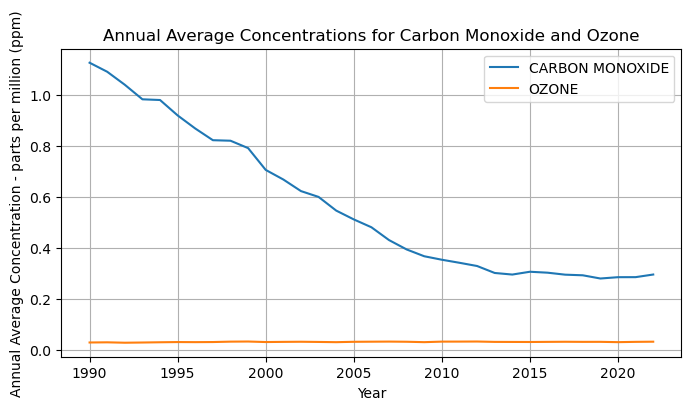

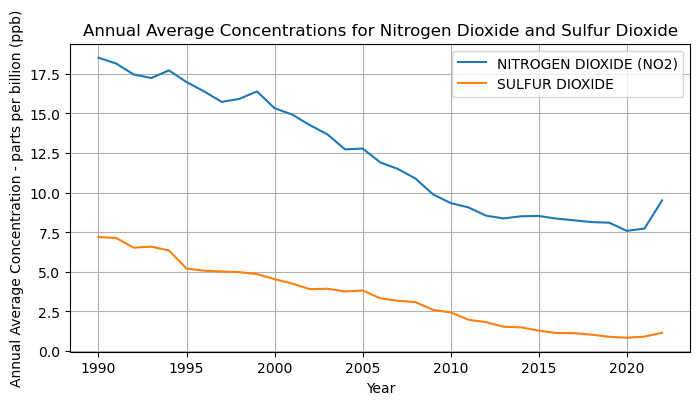

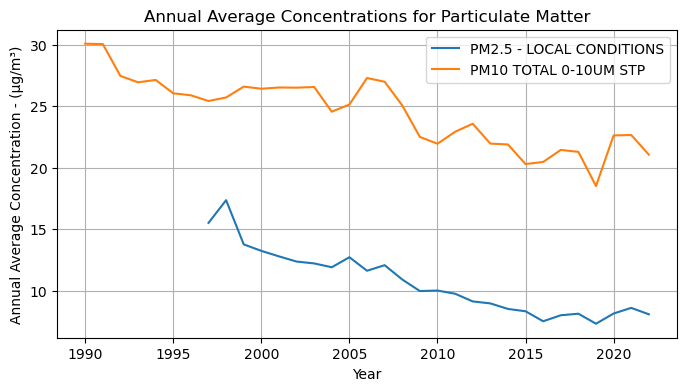

In [49]:
from pyspark.sql.functions import year, avg, col
import matplotlib.pyplot as plt

# Get the distinct parameter names
parameter_names = all_pollutants_merged.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate annual average for each pollutant
annual_avg_data = {}

for parameter_name in parameter_names:
    annual_avg = all_pollutants_merged \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(year(col('date_local')).alias('year')) \
        .agg(avg(col('arithmetic_mean')).alias(f'annual_avg_{parameter_name}')) \
        .orderBy('year') \
        .toPandas()
    annual_avg_data[parameter_name] = annual_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide', 'Ozone']
chart2_pollutants = ['Nitrogen dioxide (NO2)', 'Sulfur dioxide']
chart3_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the annual average concentrations for Chart 1 pollutants
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    annual_avg_pd = annual_avg_data[parameter_name]
    plt.plot(annual_avg_pd['year'], annual_avg_pd[f'annual_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration - parts per million (ppm)')
plt.title('Annual Average Concentrations for Carbon Monoxide and Ozone')
plt.legend()
plt.grid()
plt.show()

# Plot the annual average concentrations for Chart 2 pollutants
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    annual_avg_pd = annual_avg_data[parameter_name]
    plt.plot(annual_avg_pd['year'], annual_avg_pd[f'annual_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration - parts per billion (ppb)')
plt.title('Annual Average Concentrations for Nitrogen Dioxide and Sulfur Dioxide')
plt.legend()
plt.grid()
plt.show()

# Plot the annual average concentrations for Chart 3 pollutants
plt.figure(figsize=(8, 4))

for parameter_name in chart3_pollutants:
    annual_avg_pd = annual_avg_data[parameter_name]
    plt.plot(annual_avg_pd['year'], annual_avg_pd[f'annual_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration - (µg/m³)')
plt.title('Annual Average Concentrations for Particulate Matter')
plt.legend()
plt.grid()
plt.show()

### 4.6. Case Study: AQI in New York

In order to capture a visual representation of AQI, the index driven by each of these six pollutants, we plotted the following AQI lifecycle for site 0005, ALBANY COUNTY HEALTH DEPT in New York State.  While the mean AQI, shown by the bold line, consistently remains in the Good and Moderate zones, individual months were marked by Very Unhealthy AQI.

Since AQI is measured for each pollutant, the graph that follows captures all air quality indices for each of the six pollutants we are tracking. AQI is a 0-500 scale representing the potential health concerns posed by concentrations of airborne pollutants. 0-50 AQI is considered Good, 50-100 is Moderate, 100-150 is Unhealthy for Sensitive Groups--such as those with breathing problems or cardiovascular conditions, 150-200 is Unhealthy, 200-300 is Very Unhealthy, and over 300 is Hazardous.  For certain pollutants, like PM2.5, AQI can exceed 500, although the EPA does not have a designated category for these extreme indices.

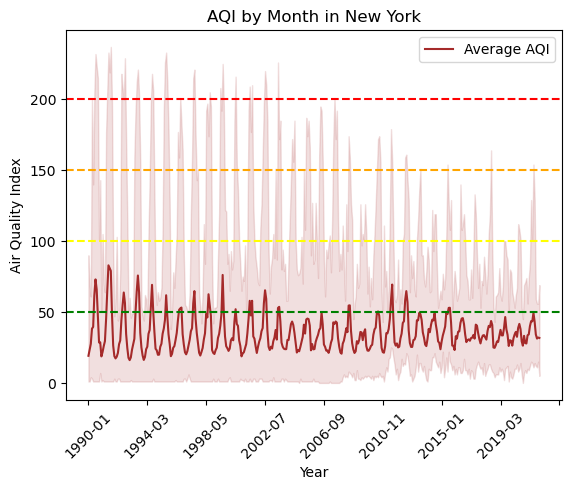

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from pyspark.sql.functions import when, col, min, max, avg
from pyspark.sql.functions import year, month, date_trunc

# Define the conditions for each aqi category
condition1 = (col("aqi") > 0) & (col("aqi") <= 50)
condition2 = (col("aqi") > 50) & (col("aqi") <= 100)
condition3 = (col("aqi") > 100)& (col("aqi") <= 150)
condition4 = (col("aqi") > 150) & (col("aqi") <= 200)
condition5 = (col("aqi") > 200) & (col("aqi") <= 300)
condition6 = (col("aqi") > 300)

# Apply the conditions and set the values for each category
AQILevel = when(condition1, "Good") \
                .when(condition2, "Moderate") \
                .when(condition3, "Unhealthy for Sensitive Groups") \
                .when(condition4, "Unhealthy") \
                .when(condition5,"Very Unhealthy") \
                .when(condition6,"Hazardous") \
                .otherwise("Unknown")

# Add the new column to the DataFrame
all_pollutants_merged = all_pollutants_merged.withColumn("AQI Level", AQILevel)

# Isolate site_num 0010 & state_code 34 = New York
ny_daily = all_pollutants_merged.where((all_pollutants_merged['state_code'] == '34') &
                                      (all_pollutants_merged['site_num'] == '0005'))

# Change the date into the first day of month
ny_daily = ny_daily.withColumn("year_month", date_trunc("month", "date_local"))

# Calculate average, min, and max AQI
ny_monthly = ny_daily.groupBy("year_month").agg(min("aqi"), max("aqi"), avg("aqi"))
ny_monthly_pd = ny_monthly.select("year_month","max(aqi)","min(aqi)","avg(aqi)").toPandas()
ny_monthly_pd['year_month'] = ny_monthly_pd['year_month'].dt.strftime('%Y-%m')
ny_monthly_pd = ny_monthly_pd.sort_values('year_month')

# Plot the lines for min, max, and avg
ax = ny_monthly_pd.plot(x='year_month', y='avg(aqi)', color = 'brown')
ax.fill_between(x = 'year_month', y1='min(aqi)', y2='max(aqi)', 
                data=ny_monthly_pd,color=mpl.colors.to_rgba('brown', 0.15))
ax.legend(labels=["Average AQI"], loc='upper right')

# Draw the horizontal lines for AQI level
plt.axhline(y = 50, color='green', linestyle='--')
plt.axhline(y = 100, color='yellow', linestyle='--')
plt.axhline(y = 150, color='orange', linestyle='--')
plt.axhline(y = 200, color='red', linestyle='--')
#plt.axhline(y = 300, color='purple', linestyle='--')

# Set the axis labels and title and plot the graph
plt.xlabel('Year')
plt.ylabel('Air Quality Index')
plt.xticks(rotation = 45)
plt.title('AQI by Month in New York')
plt.show()

### 4.7. State Event Type Count  

The EPA Historical Air Quality data set also includes information on events that are known to impact air quality.  Some examples of exceptional events are wildfire, high wind dust events, prescribed fires，stratospheric ozone intrusion，and volcanic and seismic activities. The table and graph that follow show that California has the highest event count of any state. Drawing on information from the New York Times, we assess the following to be drivers in California's high count of events (Pierre-Louis & Schwartz, 2021).

> 1. __Climate__: California has a Mediterranean climate, which means it has long, dry summers with high temperatures and low humidity. These conditions are ideal for creating dry vegetation that is prone to wildfires. One example is 2020 wildfire where over 9,600 fires burned more than 4 million acres of land. 

> 2. __Geography__: California is located on the Pacific Ring of Fire, which is a region of high volcanic and seismic activity. In 2021, the state experienced a series of small earthquakes in the San Francisco Bay Area, with the largest measuring at a magnitude of 3.8 on the Richter scale.

> 3. __Human Activities__: Many wildfires in California are caused by human activity, such as unattended campfires, discarded cigarettes, and arson. The high population density in some parts of the state can also increase the risk of exceptional events.

It's worth noting that wildfires are a natural part of California's ecosystem, and some degree of wildfire activity is necessary for maintaining healthy ecosystems. However, the frequency and severity of events in recent years has raised concerns about their impact on people and property.


In [50]:
# Find the total counts in each state 
from pyspark.sql.functions import desc, col,count
state_included_event = all_pollutants_merged.select("state_name","event_type","arithmetic_mean")\
                  .where(all_pollutants_merged.event_type == "Included")\
                   .groupBy("state_name").agg(count("state_name").alias("Included Count")
                                             ).orderBy(desc("Included Count"))

state_excluded_event = all_pollutants_merged.select("state_name","event_type","arithmetic_mean")\
                  .where(all_pollutants_merged.event_type == "Excluded")\
                   .groupBy("state_name").agg(count("state_name").alias("Excluded Count")
                                             ).orderBy(desc("Excluded Count"))

event_table = state_included_event.join(state_excluded_event, on = "state_name", how ="left_outer")

count_table = event_table.withColumn('Total Count', col('Included Count') + col('Excluded Count'))
count_table.orderBy(desc('Total Count')).limit(10).toPandas()

,state_name,Included Count,Excluded Count,Total Count
0,California,159118,1659,160777
1,Hawaii,76970,31378,108348
2,Michigan,101416,12,101428
3,Indiana,87961,1,87962
4,Colorado,76566,522,77088
5,North Carolina,65842,16,65858
6,Tennessee,49024,177,49201
7,Texas,48450,211,48661
8,Kentucky,45382,407,45789
9,North Dakota,42685,6,42691


In the table above, `Included` events are those that the EPA was able to measure.  `Excluded` events were those that took place where an air quality measurement was not captured.  `Total Count` is the sum of both types of events.

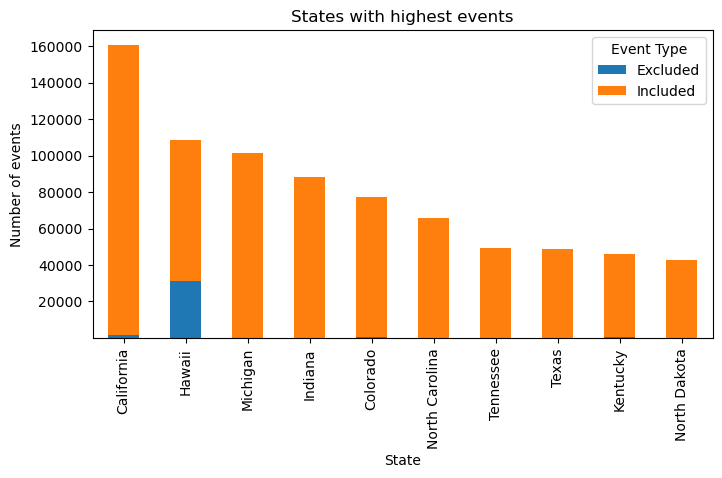

In [52]:
# Bar Plot of Top 10 event count states 
from pyspark.sql.functions import col, count
import pandas as pd
import matplotlib.pyplot as plt

# Replace ‘dataframe’ with the appropriate DataFrame variable containing state and event type info
# Replace ‘state_column’ and ‘event_type_column’ with the appropriate column names for state & event type
# Filter out the rows with ‘None’ as event type
filtered_df = all_pollutants_merged.filter(col('event_type') != 'None')

# Group by state and event type, and count the number of occurrences for each state
state_event_counts = filtered_df.groupBy('state_name', 'event_type') \
     .agg(count('event_type').alias('event_type_count')) \
     .toPandas()

# Calculate the total count for each state
state_total_counts = state_event_counts.groupby('state_name')['event_type_count'].sum().reset_index()

# Get the top 10 states by total count and sort by descending order
top_10_states = state_total_counts.nlargest(10, 'event_type_count').sort_values(by='event_type_count', 
                                                                                ascending=False)
# Filter the state_event_counts DataFrame to include only the top 10 states
state_event_counts_top_10 = state_event_counts[state_event_counts['state_name']
                                               .isin(top_10_states['state_name'])]

# Create a pivot table with the top 10 states
pivot_table = state_event_counts_top_10.pivot_table(index='state_name', columns='event_type', 
                                                    values='event_type_count', fill_value=0)

# Sort the pivot table by the total event type count in descending order
pivot_table['total_event_type_count'] = pivot_table.sum(axis=1)
pivot_table_sorted = pivot_table.sort_values(by='total_event_type_count', 
                                             ascending=False).drop('total_event_type_count', axis=1)

# Create a stacked bar plot of event type count for the top 10 states ordered by total event type count
pivot_table_sorted.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.xlabel('State')
plt.ylabel('Number of events')
plt.title('States with highest events')
plt.legend(title='Event Type')
plt.show()

The above table makes clear that California has the highest number of recorded climate events.  Hawaii has the highest number of `Excluded` events. This may be due in part to the island state's few sites, or perhaps its geographic separation from the contiguous United States.  We will explore events more in the next version of this notebook.

### 4.8. Case Study: Seasonality Trends for Pollutants in California

The results show that Carbon Monoxide and Nitrogen Dioxide have lower average concentrations during the spring and summer months (April to August), while Ozone tends to increase during these months. In contrast, Sulfur Dioxide and PM2.5 exhibit higher average concentrations during the winter months (October to December). Notably, there is a clear decrease in average PM10 concentrations from October to December.

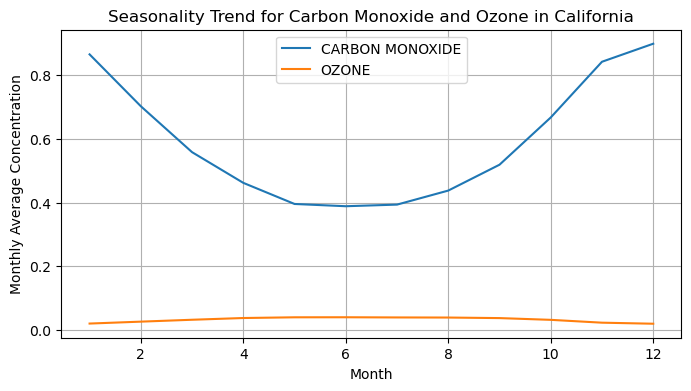

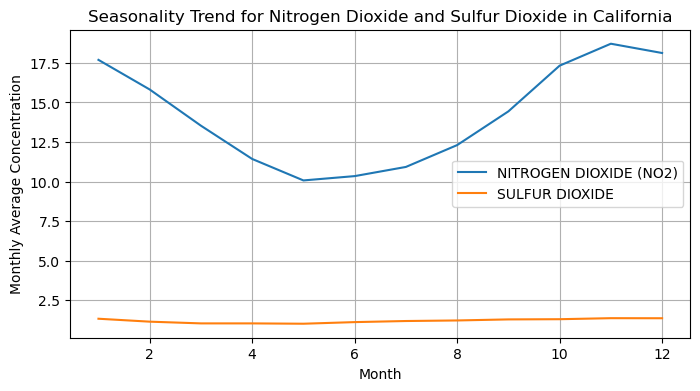

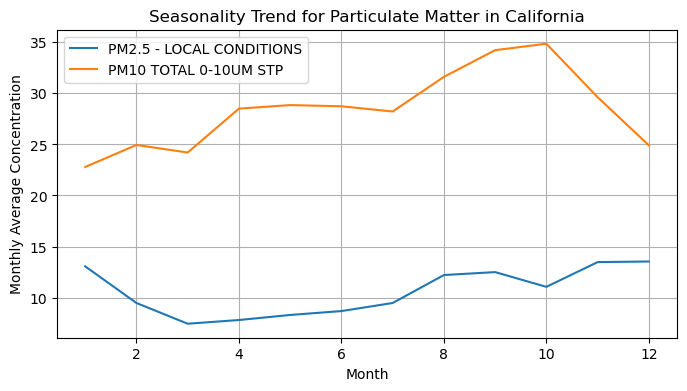

In [21]:
from pyspark.sql.functions import month, avg, col
import matplotlib.pyplot as plt

# Filter the data for California only
cali = all_pollutants_merged.filter(col('state_name') == 'California')

# Get the distinct parameter names
parameter_names = cali.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate monthly average for each pollutant
monthly_avg_data = {}

for parameter_name in parameter_names:
    monthly_avg = cali \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(month(col('date_local')).alias('month')) \
        .agg(avg(col('arithmetic_mean')).alias(f'monthly_avg_{parameter_name}')) \
        .orderBy('month') \
        .toPandas()
    monthly_avg_data[parameter_name] = monthly_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide', 'Ozone']
chart2_pollutants = ['Nitrogen dioxide (NO2)', 'Sulfur dioxide']
chart3_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the monthly average concentrations for CO and O3
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('Seasonality Trend for Carbon Monoxide and Ozone in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for NO2 and SO2
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('Seasonality Trend for Nitrogen Dioxide and Sulfur Dioxide in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for PM
plt.figure(figsize=(8, 4))

for parameter_name in chart3_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('Seasonality Trend for Particulate Matter in California')
plt.legend()
plt.grid()
plt.show()

<a id="part5"></a>
## Part 5: Conclusions and Future Scope

From the first phase of our study on the EPA Historical Air Quality data set, we learned that the EPA monitors air quality across the United States with 3,327 distinct measurement sites.  Our data set includes measurement from 1990 to 2022.

Since the inception of the Clean Air Act of 1990, air quality has drastically improved in aggregate across the United States. This is indicated by steep declines in daily measurements of Carbon Monoxide (CO), Sulfur Dioxide (SO2), Nitrogen Dioxide (NO2), and Particulate Matter 2.5 (PM2.5) and 10 (PM10), although Atmospheric Ozone (O3) has remained fairly constant in recent history. It is worth noting that the standard deviation for NO2, SO2, and PM2.5 and PM10 were much higher in comparision with CO and O3. 

We know, however that the Clean Air Act of 1990 is not the only legislation enacted in the U.S. to restrict pollutants, so in the next version of this notebook we will look more closely at California whose legislature passed additional Ambient Air Quality Standards in 2002, 2006, and 2008 (California Air Resources Board). Our early exploratory data analysis revealed that California leads all other U.S. States in climate events that may impact air quality. These events include things like wildfires, earthquakes, and volcanic activity. In an effort to better understand the interaction of air quality and events, we will conduct future analyses into the immediate aftermath of events that caused an observable spike in AQI. 

Finally, we demonstrated the seasonality of most pollutants, which may be an indicator that temperature and wind also influence airborne concentrations of pollution with changing seasons.  This will also be focal point of our future work.

----


<a id="part6"></a>
## Part 6: References

> 1. AirNow (2023). Air Quality Index - A Guide to Air Quality and Your Health. _AirNow_. https://www.airnow.gov/aqi/aqi-basics/
> 2. OpenAI (2023). Chat with GPT-3.5. _OpenAI_. https://chat.openai.com/chat.
> 3. Story, R. (2013). Python Visualization: Folium 0.14.0 Quickstart. _Folium_. https://python-visualization.github.io/folium/quickstart.html#Getting-Started
> 4. United States Environmental Protection Agency (2022). Historical Air Quality by the EPA. _Google Cloud_. https://console.cloud.google.com/marketplace/product/epa/historical-air-quality
> 5. United States Environmental Protection Agency (2015). File Formats. _AQS Data Mart_. https://aqs.epa.gov/aqsweb/airdata/FileFormats.html
> 6. Pierre-Louis, K., Schwartz, J. (2021, July 16). Why Does California Have So Many Wildfires? _The New York Times_. https://www.nytimes.com/article/why-does-california-have-wildfires.html
> 7. California Air Resources Board (2023). California Ambient Air Quality Standards. _State of California_. https://ww2.arb.ca.gov/resources/california-ambient-air-quality-standards#:~:text=In%201959%20California%20enacted%20legislation,more%20stringent%20than%20national%20standards




----


<a id="appa"></a>

## Appendix A

__Map of EPA Air Pollutant Measurement Sites__

<a href="https://ibb.co/MgvT6jX"><img src="https://i.ibb.co/p17Dysm/Screenshot-2023-04-04-143748.png" alt="Screenshot-2023-04-04-143748" border="0" /></a>